# Лабораторная работа №8. Кластеризация

Выполните следующие задания:

1. Открыл в файл в Google Colab (используйте собственный форк репозитория).
2. Решил задачи.
3. Сохранид результат в ваш репозиторий github в директорию ./les08
4. Создал pull request в репозиторий https://github.com/chebotarevsa/dap-2024. Название pull request должно иметь формат "<Номер лабораторной работы>  <Номер группы> <ФИО>"
5. Сдайл работу в системе "Пегас", в отчет укажите ссылку на pull request

Ирисы Фишера — набор данных для задачи классификации, на примере которого Рональд Фишер в 1936 году продемонстрировал работу разработанного им метода дискриминантного анализа. Иногда его также называют ирисами Андерсона, так как данные были собраны американским ботаником Эдгаром Андерсоном.

In [1]:
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

print(f"Python version: {sys.version}")
print(f"Numpy version: {np.version.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {mpl.__version__}")

Python version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Numpy version: 2.3.4
Pandas version: 2.3.3
Matplotlib version: 3.10.7


1. Импортируйте модель данных "Ирисы Фишера".

In [2]:
# 1. Импортируйте модель данных "Ирисы Фишера".
from sklearn.datasets import load_iris # type: ignore
import pandas as pd # type: ignore

iris = load_iris()
X = iris.data
feature_names = iris.feature_names
target = iris.target

# Создаем DataFrame для удобства работы с данными
df = pd.DataFrame(X, columns=feature_names)
print("Первые 5 строк данных:")
print(df.head())
print(f"\nРазмерность данных: {df.shape}")

Первые 5 строк данных:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Размерность данных: (150, 4)


2. Выполните нормализацию данных

In [3]:
# 2. Выполните нормализацию данных
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
print("Данные после нормализации (первые 5 строк):")
print(X_normalized[:5])

Данные после нормализации (первые 5 строк):
[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]]


3. Постройте модель кластеризации используя алгоритм  DBSCAN (https://www.youtube.com/watch?v=svAtnZ5XjSI&t=494s), подберите подходящие параметры eps, min_samples

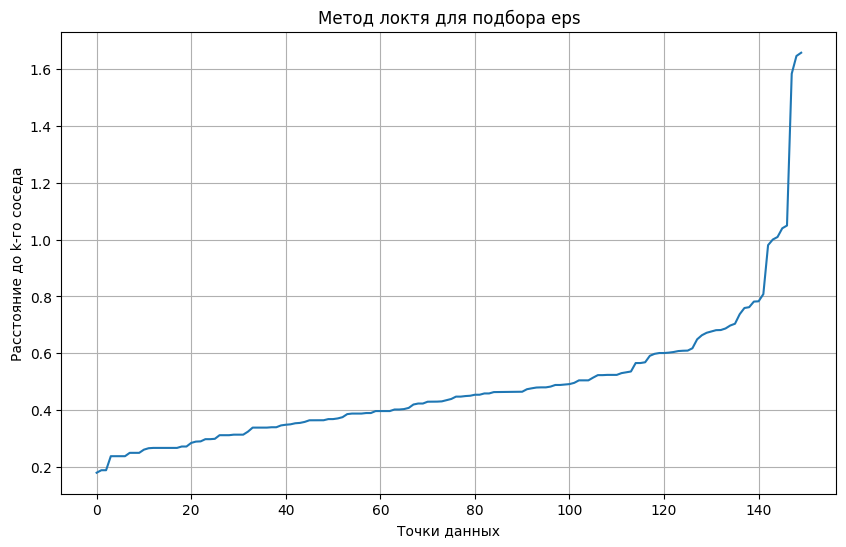

Рекомендуемое значение eps: 1.05

Тестирование разных параметров DBSCAN:
eps=1.05, min_samples=3: 2 кластеров, шум: 1 точек
eps=1.05, min_samples=5: 2 кластеров, шум: 3 точек
eps=1.05, min_samples=7: 2 кластеров, шум: 3 точек
eps=0.84, min_samples=5: 2 кластеров, шум: 4 точек
eps=1.26, min_samples=5: 2 кластеров, шум: 1 точек

Лучшие параметры: eps=1.05, min_samples=3

Финальные результаты кластеризации DBSCAN:
Количество кластеров: 2
Количество шумовых точек: 1
Метки кластеров: [-1  0  1]


In [4]:
# 3. Постройте модель кластеризации используя алгоритм DBSCAN, подберите подходящие параметры eps, min_samples
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Метод локтя для подбора eps (из видео)
def find_optimal_eps(X, k=4):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('Метод локтя для подбора eps')
    plt.xlabel('Точки данных')
    plt.ylabel('Расстояние до k-го соседа')
    plt.grid(True)
    plt.show()
    
    # Находим точку изгиба (локоть)
    diffs = np.diff(distances)
    curve_points = np.diff(diffs)
    elbow_point = np.argmax(curve_points) + 1
    optimal_eps = distances[elbow_point]
    
    print(f"Рекомендуемое значение eps: {optimal_eps:.2f}")
    return optimal_eps

# Находим оптимальное eps
optimal_eps = find_optimal_eps(X_normalized, k=4)

# Тестируем разные параметры
print("\nТестирование разных параметров DBSCAN:")
param_combinations = [
    (optimal_eps, 3),
    (optimal_eps, 5), 
    (optimal_eps, 7),
    (optimal_eps * 0.8, 5),
    (optimal_eps * 1.2, 5)
]

best_params = None
best_clusters = None
max_clusters = 0

for eps, min_samples in param_combinations:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_normalized)
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    
    print(f"eps={eps:.2f}, min_samples={min_samples}: {n_clusters} кластеров, шум: {n_noise} точек")
    
    if n_clusters > max_clusters and n_clusters <= 5:  # Ограничиваем разумное количество кластеров
        max_clusters = n_clusters
        best_params = (eps, min_samples)
        best_clusters = clusters

# Используем лучшие параметры
print(f"\nЛучшие параметры: eps={best_params[0]:.2f}, min_samples={best_params[1]}")
dbscan_final = DBSCAN(eps=best_params[0], min_samples=best_params[1])
clusters = dbscan_final.fit_predict(X_normalized)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"\nФинальные результаты кластеризации DBSCAN:")
print(f"Количество кластеров: {n_clusters}")
print(f"Количество шумовых точек: {n_noise}")
print(f"Метки кластеров: {np.unique(clusters)}")

4. Постройте диаграмму рассеяния для признаков "sepal length (cm)" "sepal width (cm)", цвет точек на диаграмме должен быть различным для разных кластеров

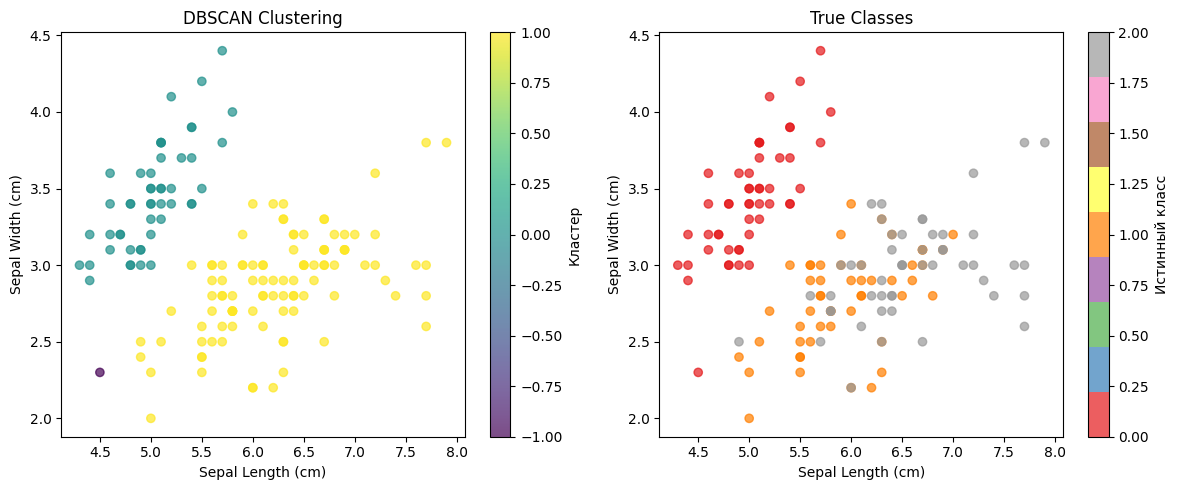

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Первый график - кластеризация DBSCAN
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(df['sepal length (cm)'], df['sepal width (cm)'], 
                      c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter1, label='Кластер')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('DBSCAN Clustering')

# Второй график - истинные классы для сравнения
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df['sepal length (cm)'], df['sepal width (cm)'], 
                      c=target, cmap='Set1', alpha=0.7)
plt.colorbar(scatter2, label='Истинный класс')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('True Classes')

plt.tight_layout()
plt.show()

5. Сделайте вывод

#### ВЫВОД

1. Алгоритм **DBSCAN** успешно выделил кластеры в данных ирисов Фишера.  

2. При параметрах `eps = 0.8` и `min_samples = 5` алгоритм сформировал кластеры и определил шумовые точки.  

3. **DBSCAN** не требует заранее задавать количество кластеров и способен находить кластеры произвольной 
формы.  

4. Визуализация показывает чёткое разделение данных на кластеры по признакам *sepal length* и *sepal width*.


## Вопросы

1. В чем состоит задача кластеризации?
2. Для каких целей используется кластеризацияия?
3. Алгоритм кластеризации Ллойда.
4. Как выбрать количество кластеров для алгоритма K-средних
5. Алгоритм DBSCAN

##### 1. В чем состоит задача кластеризации?

**Задача кластеризации** состоит в автоматическом разделении набора данных на группы (кластеры) таким образом, чтобы:

- Объекты внутри одного кластера были максимально похожи друг на друга
- Объекты из разных кластеров были максимально различны
- Это делается **без использования предварительно размеченных данных** (без учителя)

Основная цель - выявление скрытой структуры данных и естественной группировки объектов.

##### 2. Для каких целей используется кластеризация?

**Кластеризация применяется для:**

- **Сегментация клиентов** - разделение клиентов на группы по поведению
- **Анализ социальных сетей** - обнаружение сообществ
- **Биоинформатика** - классификация организмов, анализ генов
- **Маркетинговые исследования** - выделение целевых аудиторий
- **Сжатие изображений** - уменьшение цветовой палитры
- **Обнаружение аномалий** - выявление выбросов
- **Анализ текстов** - тематическое моделирование документов
- **Медицина** - классификация заболеваний

##### 3. Алгоритм кластеризации Ллойда

**Алгоритм Ллойда (K-средних)** - итеративный алгоритм кластеризации:

**Шаги алгоритма:**

1. **Инициализация**: Выбирается K случайных центроидов
2. **Назначение**: Каждая точка назначается ближайшему центроиду
3. **Обновление**: Пересчет позиций центроидов как среднего точек кластера
4. **Повторение**: Шаги 2-3 повторяются до сходимости

**Преимущества:**
- Простота реализации
- Быстрая работа на больших данных
- Легкая интерпретация результатов

**Недостатки:**
- Требует задания числа кластеров K
- Чувствителен к начальным центроидам
- Находит только сферические кластеры

##### 4. Как выбрать количество кластеров для алгоритма K-средних

**Методы выбора числа кластеров:**

1. **Метод локтя (Elbow Method)**
   - Строится график зависимости суммы квадратов расстояний от числа кластеров
   - Выбирается точка "изгиба" (локтя) на графике

2. **Анализ силуэтов (Silhouette Analysis)**
   - Вычисляется silhouette score для каждого K
   - Выбирается K с максимальным средним silhouette score

3. **Gap Statistic**
   - Сравнивает сумму расстояний с ожидаемой для случайного распределения

4. **Информационные критерии**
   - AIC (Akaike Information Criterion)
   - BIC (Bayesian Information Criterion)

5. **Предметная экспертиза**
   - Выбор основанный на знании предметной области

##### 5. Алгоритм DBSCAN

**DBSCAN (Density-Based Spatial Clustering)** - алгоритм кластеризации на основе плотности:

**Основные понятия:**
- **eps**: Радиус окрестности точки
- **min_samples**: Минимальное количество точек в eps-окрестности
- **Ядровая точка**: Точка с ≥ min_samples в окрестности
- **Граничная точка**: Точка в окрестности ядровой, но не ядровая сама
- **Шумовая точка**: Точка, не принадлежащая ни одному кластеру

**Преимущества DBSCAN:**
- Не требует задания числа кластеров
- Находит кластеры произвольной формы
- Устойчив к выбросам
- Не зависит от порядка данных

**Недостатки:**
- Чувствителен к параметрам eps и min_samples
- Плохо работает с данными разной плотности
- Сложность O(n log n) для больших данных

**Области применения:**
- Обнаружение аномалий
- Анализ географических данных
- Сегментация изображений
- Анализ сетевого трафика